In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Creating Dataframes by Loading CSV Files

In [2]:
df_0_shot = pd.read_csv('../results/mbpp_correct/mbpp_0_shot.csv')
df_3_shot = pd.read_csv('../results/mbpp_correct/mbpp_3_shot.csv')

In [3]:
df_0_shot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18896 entries, 0 to 18895
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LLM                          18896 non-null  object 
 1   Benchmark prompt             18896 non-null  object 
 2   Execution time (s)           18896 non-null  float64
 3   CPU Energy (J)               18896 non-null  float64
 4   RAM Energy (J)               18896 non-null  float64
 5   GPU Energy (J)               18896 non-null  float64
 6   CPU Power (W)                18896 non-null  float64
 7   RAM Power (W)                18896 non-null  float64
 8   GPU Power (W)                18896 non-null  float64
 9   CO2 emissions (Kg)           18896 non-null  float64
 10  CO2 emissions rate (Kg/s)    18896 non-null  float64
 11  MBPP (unsanitized) pass@1    18896 non-null  float64
 12  MBPP+ (unsanitized) pass@1   18896 non-null  float64
 13  MBPP (sanitized)

In [4]:
df_3_shot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26250 entries, 0 to 26249
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LLM                          26250 non-null  object 
 1   Benchmark prompt             26250 non-null  object 
 2   Execution time (s)           26250 non-null  float64
 3   CPU Energy (J)               26250 non-null  float64
 4   RAM Energy (J)               26250 non-null  float64
 5   GPU Energy (J)               26250 non-null  float64
 6   CPU Power (W)                26250 non-null  float64
 7   RAM Power (W)                26250 non-null  float64
 8   GPU Power (W)                26250 non-null  float64
 9   CO2 emissions (Kg)           26250 non-null  float64
 10  CO2 emissions rate (Kg/s)    26250 non-null  float64
 11  MBPP (unsanitized) pass@1    26250 non-null  float64
 12  MBPP+ (unsanitized) pass@1   26250 non-null  float64
 13  MBPP (sanitized)

### Cast data types

In [5]:
# Converting 'LLM' and 'Benchmark prompt' to string
df_0_shot['LLM'] = df_0_shot['LLM'].astype(str)
df_0_shot['Benchmark prompt'] = df_0_shot['Benchmark prompt'].astype(str)

df_3_shot['LLM'] = df_0_shot['LLM'].astype(str)
df_3_shot['Benchmark prompt'] = df_0_shot['Benchmark prompt'].astype(str)

### Remove outliers

In [6]:
# Function to remove outliers using the IQR method and return the number of removed outliers and original count
def remove_outliers_and_count(group):
    # Calculate IQR for 'CPU Energy (J)'
    Q1 = group['CPU Energy (J)'].quantile(0.25)
    Q3 = group['CPU Energy (J)'].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the data to remove outliers
    filtered_group = group[(group['CPU Energy (J)'] >= lower_bound) & (group['CPU Energy (J)'] <= upper_bound)]
    
    # Calculate the number of outliers removed
    num_removed = len(group) - len(filtered_group)
    
    # Return the filtered group and the number of removed outliers, as well as the original count
    return filtered_group, num_removed, len(group)

# Initialize lists to store the number of outliers removed and original counts for each subset
outliers_list_0 = []
outliers_list_3 = []

# Remove outliers and count them for df_0_shot
df_0_no_outliers_list = []
for (llm, prompt), group in df_0_shot.groupby(['LLM', 'Benchmark prompt']):
    filtered_group, num_removed, original_count = remove_outliers_and_count(group)
    df_0_no_outliers_list.append(filtered_group)
    outliers_list_0.append([llm, prompt, num_removed, original_count])  # Store original count

df_0_no_outliers = pd.concat(df_0_no_outliers_list).reset_index(drop=True)

# Remove outliers and count them for df_3_shot
df_3_no_outliers_list = []
for (llm, prompt), group in df_3_shot.groupby(['LLM', 'Benchmark prompt']):
    filtered_group, num_removed, original_count = remove_outliers_and_count(group)
    df_3_no_outliers_list.append(filtered_group)
    outliers_list_3.append([llm, prompt, num_removed, original_count])  # Store original count

df_3_no_outliers = pd.concat(df_3_no_outliers_list).reset_index(drop=True)

In [7]:
# Create DataFrames to hold the outliers list with original counts
columns = ['LLM', 'Benchmark prompt', 'Outliers removed', 'Original count']
df_outliers_0 = pd.DataFrame(outliers_list_0, columns=columns)
df_outliers_3 = pd.DataFrame(outliers_list_3, columns=columns)

# Display the results
print("Outliers removed in df_0_shot:")
df_outliers_0



Outliers removed in df_0_shot:


,LLM,Benchmark prompt,Outliers removed,Original count
0,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/100,0,10
1,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/101,0,10
2,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/102,0,10
3,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/103,0,10
4,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/104,0,10
...,...,...,...,...
1885,starling-lm-7b-alpha.Q5_K_S,Mbpp/95,3,10
1886,starling-lm-7b-alpha.Q5_K_S,Mbpp/96,3,10
1887,starling-lm-7b-alpha.Q5_K_S,Mbpp/97,1,10
1888,starling-lm-7b-alpha.Q5_K_S,Mbpp/98,2,10


In [8]:
print("\nOutliers removed in df_3_shot:")
df_outliers_3


Outliers removed in df_3_shot:


,LLM,Benchmark prompt,Outliers removed,Original count
0,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/100,3,10
1,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/101,0,10
2,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/102,0,10
3,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/103,1,10
4,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/104,0,10
...,...,...,...,...
1885,starling-lm-7b-alpha.Q5_K_S,Mbpp/95,2,10
1886,starling-lm-7b-alpha.Q5_K_S,Mbpp/96,1,10
1887,starling-lm-7b-alpha.Q5_K_S,Mbpp/97,1,10
1888,starling-lm-7b-alpha.Q5_K_S,Mbpp/98,1,10


### Create dataframes with all the average values

In [9]:
# List of columns to calculate the mean for
columns_to_average = ['Execution time (s)', 'CPU Energy (J)',
       'MBPP (unsanitized) pass@1', 'MBPP+ (unsanitized) pass@1',
       'MBPP (sanitized) pass@1', 'MBPP+ (sanitized) pass@1',
       'MBPP (unsanitized) pass@10', 'MBPP+ (unsanitized) pass@10',
       'MBPP (sanitized) pass@10', 'MBPP+ (sanitized) pass@10',
       'GoogleBLEU (unsanitized)', 'CodeBLEU (unsanitized)',
       'SacreBLEU (unsanitized)', 'GoogleBLEU (sanitized)',
       'CodeBLEU (sanitized)', 'SacreBLEU (sanitized)']

# Grouping by LLM and Programming Language, and calculating the mean for the specified columns
df_0_averages = df_0_no_outliers.groupby(['LLM'])[columns_to_average].mean().reset_index()
df_3_averages = df_3_no_outliers.groupby(['LLM'])[columns_to_average].mean().reset_index()

df_0_averages["SacreBLEU (unsanitized)"] = df_0_averages["SacreBLEU (unsanitized)"] / 100
df_0_averages["SacreBLEU (sanitized)"] = df_0_averages["SacreBLEU (sanitized)"] / 100

df_3_averages["SacreBLEU (unsanitized)"] = df_3_averages["SacreBLEU (unsanitized)"] / 100
df_3_averages["SacreBLEU (sanitized)"] = df_3_averages["SacreBLEU (sanitized)"] / 100

# Adicionando uma coluna para cada DataFrame
df_0_averages['Shot'] = '0-shot'
df_3_averages['Shot'] = '3-shot'

# Concatenando os DataFrames
df_combined_mbpp = pd.concat([df_0_averages, df_3_averages], ignore_index=True)
df_combined_mbpp

,LLM,Execution time (s),CPU Energy (J),MBPP (unsanitized) pass@1,MBPP+ (unsanitized) pass@1,MBPP (sanitized) pass@1,MBPP+ (sanitized) pass@1,MBPP (unsanitized) pass@10,MBPP+ (unsanitized) pass@10,MBPP (sanitized) pass@10,MBPP+ (sanitized) pass@10,GoogleBLEU (unsanitized),CodeBLEU (unsanitized),SacreBLEU (unsanitized),GoogleBLEU (sanitized),CodeBLEU (sanitized),SacreBLEU (sanitized),Shot
0,Meta-Llama-3-8B-Instruct-Q6_K,65.025119,4295.804957,0.654000,0.542000,0.686000,0.569000,0.835000,0.725000,0.837000,0.728000,0.069140,0.315794,0.062450,0.168783,0.244199,0.185539,0-shot
1,codegeex4-all-9b-Q6_K_L,17.963312,1186.304689,0.000000,0.000000,0.274000,0.212000,0.000000,0.000000,0.595000,0.489000,0.192322,0.309949,0.179499,0.176930,0.189083,0.176504,0-shot
2,codellama-7b-instruct.Q5_K_M,9.004632,662.109091,0.357000,0.293000,0.393000,0.317000,0.733000,0.611000,0.751000,0.624000,0.251664,0.282798,0.257672,0.209960,0.207058,0.207026,0-shot
3,deepseek-coder-6.7b-instruct.Q5_K_M,35.409511,2322.796528,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.101692,0.327037,0.091833,0.255243,0.260233,0.273627,0-shot
4,starling-lm-7b-alpha.Q5_K_S,79.228264,5190.564256,0.074000,0.060000,0.428000,0.354000,0.444000,0.370000,0.820000,0.698000,0.043459,0.325714,0.037512,0.191784,0.232059,0.223515,0-shot
5,Meta-Llama-3-8B-Instruct-Q6_K,8.647517,613.911741,0.189160,0.163547,0.604127,0.511740,0.677223,0.587740,0.871290,0.764774,0.187369,0.325410,0.182883,0.318412,0.308408,0.336465,3-shot
6,codegeex4-all-9b-Q6_K_L,10.429506,710.866680,0.002985,0.002583,0.279197,0.216718,0.010596,0.009204,0.599300,0.493300,0.249812,0.301450,0.247117,0.261152,0.263474,0.286508,3-shot
7,codellama-7b-instruct.Q5_K_M,9.858987,700.991839,0.094950,0.077410,0.437319,0.361766,0.458123,0.382823,0.820614,0.699084,0.072406,0.293954,0.064775,0.226306,0.252862,0.249201,3-shot
8,deepseek-coder-6.7b-instruct.Q5_K_M,10.441195,703.999028,0.000000,0.000000,0.274000,0.212000,0.000000,0.000000,0.595000,0.489000,0.232784,0.303345,0.226065,0.239559,0.244757,0.259853,3-shot
9,starling-lm-7b-alpha.Q5_K_S,8.609478,597.935969,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.156917,0.324662,0.149267,0.304485,0.297618,0.322955,3-shot


### Plots

#### Energy vs Time

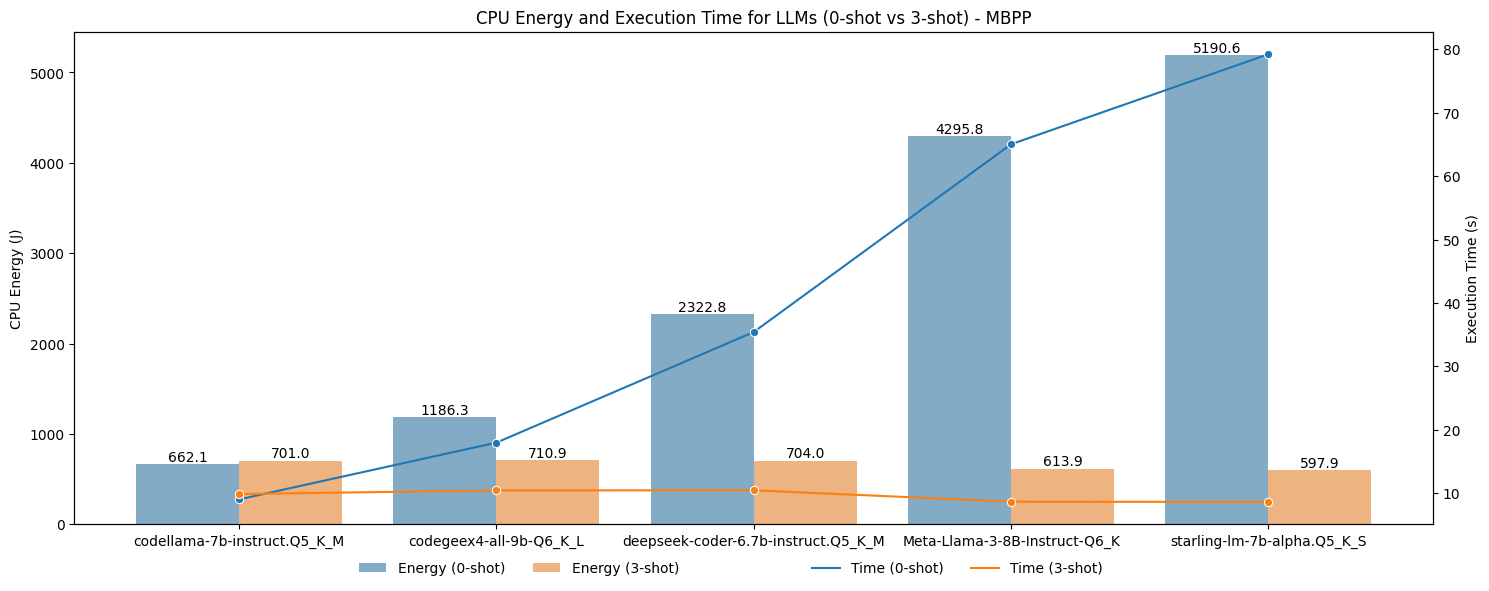

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que df_combined_mbpp já esteja declarado conforme mostrado

# Filtrando os dados para 0-shot e 3-shot
df_0_shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '0-shot'][['LLM', 'CPU Energy (J)', 'Execution time (s)']]
df_3_shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '3-shot'][['LLM', 'CPU Energy (J)', 'Execution time (s)']]

# Renomeando as colunas para facilitar a plotagem
df_0_shot.rename(columns={'CPU Energy (J)': 'Energy (0-shot)', 'Execution time (s)': 'Execution time (0-shot)'}, inplace=True)
df_3_shot.rename(columns={'CPU Energy (J)': 'Energy (3-shot)', 'Execution time (s)': 'Execution time (3-shot)'}, inplace=True)

# Fazendo um merge dos dois dataframes com base na coluna 'LLM'
df_merged = pd.merge(df_0_shot, df_3_shot, on='LLM')

# Calculando a média da energia para cada LLM
df_merged['Total Energy'] = df_merged[['Energy (0-shot)', 'Energy (3-shot)']].mean(axis=1)

# Ordenando os dados com base na energia total
df_sorted = df_merged.sort_values(by='Total Energy')

# Definindo o tamanho da figura
plt.figure(figsize=(15, 6))

# Criando um barplot para CPU Energy
barplot = sns.barplot(data=df_sorted.melt(id_vars='LLM', value_vars=['Energy (0-shot)', 'Energy (3-shot)'], var_name='Shot', value_name='CPU Energy'), 
                      x='LLM', y='CPU Energy', hue='Shot', alpha=0.6)

# Adicionando títulos e rótulos
plt.title('CPU Energy and Execution Time for LLMs (0-shot vs 3-shot) - MBPP')
plt.xlabel('')
plt.ylabel('CPU Energy (J)')

# Adicionando rótulos às barras
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.1f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', 
                     fontsize=10, color='black', 
                     rotation=0)

# Criando um segundo eixo y para Execution time
ax2 = barplot.twinx()

# Plotando o Execution time
sns.lineplot(data=df_sorted.melt(id_vars='LLM', value_vars=['Execution time (0-shot)', 'Execution time (3-shot)']),
             x='LLM', y='value', hue='variable', ax=ax2, marker='o', color='black')

# Adicionando rótulos e título para o eixo y da direita
ax2.set_ylabel('Execution Time (s)')

# Configurando a legenda para o eixo das barras (ax1)
handles1, labels1 = barplot.get_legend_handles_labels()
barplot.legend(handles1, labels1, title='', loc='upper left', bbox_to_anchor=(0.2, -0.05), ncol=2, frameon=False)

# Configurando a legenda para o eixo das linhas (ax2)
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2, ['Time (0-shot)', 'Time (3-shot)'], title='', loc='upper center', bbox_to_anchor=(0.65, -0.05), ncol=2, frameon=False)

# Exibindo o gráfico
plt.tight_layout()
plt.show()


#### Pass@k vs BLEU

In [11]:
df_combined_mbpp

,LLM,Execution time (s),CPU Energy (J),MBPP (unsanitized) pass@1,MBPP+ (unsanitized) pass@1,MBPP (sanitized) pass@1,MBPP+ (sanitized) pass@1,MBPP (unsanitized) pass@10,MBPP+ (unsanitized) pass@10,MBPP (sanitized) pass@10,MBPP+ (sanitized) pass@10,GoogleBLEU (unsanitized),CodeBLEU (unsanitized),SacreBLEU (unsanitized),GoogleBLEU (sanitized),CodeBLEU (sanitized),SacreBLEU (sanitized),Shot
0,Meta-Llama-3-8B-Instruct-Q6_K,65.025119,4295.804957,0.654000,0.542000,0.686000,0.569000,0.835000,0.725000,0.837000,0.728000,0.069140,0.315794,0.062450,0.168783,0.244199,0.185539,0-shot
1,codegeex4-all-9b-Q6_K_L,17.963312,1186.304689,0.000000,0.000000,0.274000,0.212000,0.000000,0.000000,0.595000,0.489000,0.192322,0.309949,0.179499,0.176930,0.189083,0.176504,0-shot
2,codellama-7b-instruct.Q5_K_M,9.004632,662.109091,0.357000,0.293000,0.393000,0.317000,0.733000,0.611000,0.751000,0.624000,0.251664,0.282798,0.257672,0.209960,0.207058,0.207026,0-shot
3,deepseek-coder-6.7b-instruct.Q5_K_M,35.409511,2322.796528,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.101692,0.327037,0.091833,0.255243,0.260233,0.273627,0-shot
4,starling-lm-7b-alpha.Q5_K_S,79.228264,5190.564256,0.074000,0.060000,0.428000,0.354000,0.444000,0.370000,0.820000,0.698000,0.043459,0.325714,0.037512,0.191784,0.232059,0.223515,0-shot
5,Meta-Llama-3-8B-Instruct-Q6_K,8.647517,613.911741,0.189160,0.163547,0.604127,0.511740,0.677223,0.587740,0.871290,0.764774,0.187369,0.325410,0.182883,0.318412,0.308408,0.336465,3-shot
6,codegeex4-all-9b-Q6_K_L,10.429506,710.866680,0.002985,0.002583,0.279197,0.216718,0.010596,0.009204,0.599300,0.493300,0.249812,0.301450,0.247117,0.261152,0.263474,0.286508,3-shot
7,codellama-7b-instruct.Q5_K_M,9.858987,700.991839,0.094950,0.077410,0.437319,0.361766,0.458123,0.382823,0.820614,0.699084,0.072406,0.293954,0.064775,0.226306,0.252862,0.249201,3-shot
8,deepseek-coder-6.7b-instruct.Q5_K_M,10.441195,703.999028,0.000000,0.000000,0.274000,0.212000,0.000000,0.000000,0.595000,0.489000,0.232784,0.303345,0.226065,0.239559,0.244757,0.259853,3-shot
9,starling-lm-7b-alpha.Q5_K_S,8.609478,597.935969,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.156917,0.324662,0.149267,0.304485,0.297618,0.322955,3-shot


#### Pass@1 and Pass@10

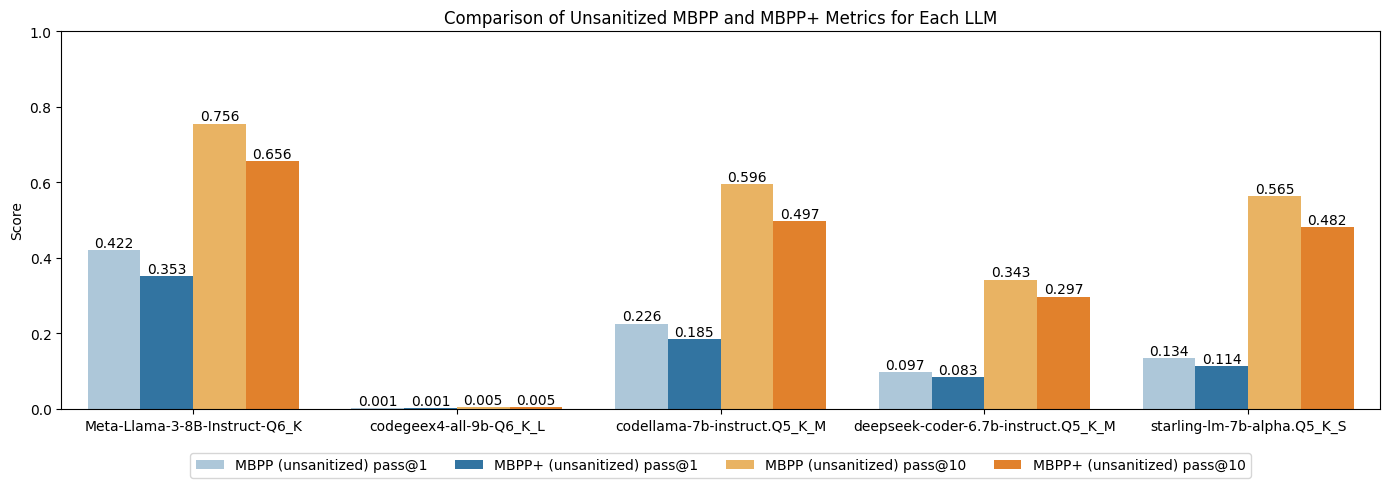

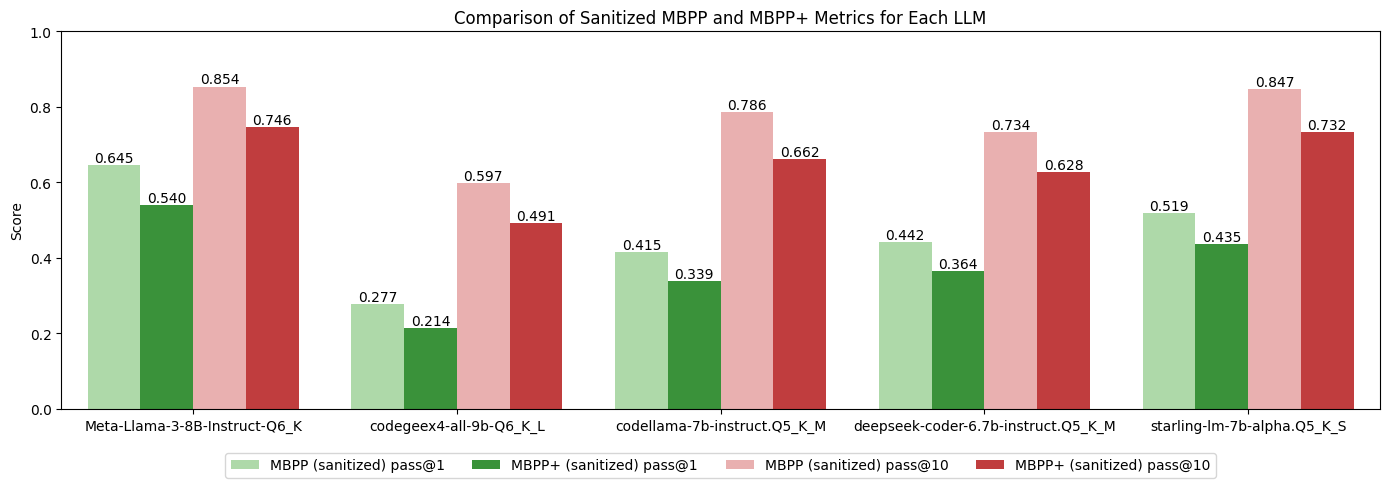

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_combined_mbpp is already defined

# Melt the DataFrame for unsanitized metrics
df_melted_unsanitized = df_combined_mbpp.melt(
    id_vars=['LLM', 'Shot'], 
    value_vars=[
        'MBPP (unsanitized) pass@1',
        'MBPP+ (unsanitized) pass@1',
        'MBPP (unsanitized) pass@10',
        'MBPP+ (unsanitized) pass@10'
    ], 
    var_name='Metric', 
    value_name='Score'
)

# Melt the DataFrame for sanitized metrics
df_melted_sanitized = df_combined_mbpp.melt(
    id_vars=['LLM', 'Shot'], 
    value_vars=[
        'MBPP (sanitized) pass@1',
        'MBPP+ (sanitized) pass@1',
        'MBPP (sanitized) pass@10',
        'MBPP+ (sanitized) pass@10'
    ], 
    var_name='Metric', 
    value_name='Score'
)

# Define custom palette for unsanitized metrics
palette_unsanitized = {
    'MBPP (unsanitized) pass@1': '#a6c8e0',   # Light blue
    'MBPP+ (unsanitized) pass@1': '#1f77b4',  # Dark blue
    'MBPP (unsanitized) pass@10': '#ffb84d',   # Light orange
    'MBPP+ (unsanitized) pass@10': '#ff7f0e'   # Dark orange
}

# Define custom palette for sanitized metrics
palette_sanitized = {
    'MBPP (sanitized) pass@1': '#a8e1a1',   # Light green
    'MBPP+ (sanitized) pass@1': '#2ca02c',  # Dark green
    'MBPP (sanitized) pass@10': '#f2a6a6',  # Light red
    'MBPP+ (sanitized) pass@10': '#d62728'   # Dark red
}

# Plotting the graph for unsanitized metrics
plt.figure(figsize=(14, 5))
ax = sns.barplot(data=df_melted_unsanitized, x='LLM', y='Score', hue='Metric', ci=None, palette=palette_unsanitized, dodge=True)

plt.title("Comparison of Unsanitized MBPP and MBPP+ Metrics for Each LLM")
plt.xlabel("")
plt.ylabel("Score")
plt.ylim(0, 1)

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

# Place the legend below the plot and centered
plt.legend(title=None, bbox_to_anchor=(0.5, -0.15), loc='center', ncol=4)

plt.grid(False)
plt.tight_layout()
plt.show()

# Plotting the graph for sanitized metrics
plt.figure(figsize=(14, 5))
ax = sns.barplot(data=df_melted_sanitized, x='LLM', y='Score', hue='Metric', ci=None, palette=palette_sanitized, dodge=True)

plt.title("Comparison of Sanitized MBPP and MBPP+ Metrics for Each LLM")
plt.xlabel("")
plt.ylabel("Score")
plt.ylim(0, 1)

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

# Place the legend below the plot and centered
plt.legend(title=None, bbox_to_anchor=(0.5, -0.15), loc='center', ncol=4)

plt.grid(False)
plt.tight_layout()
plt.show()



#### BLEU

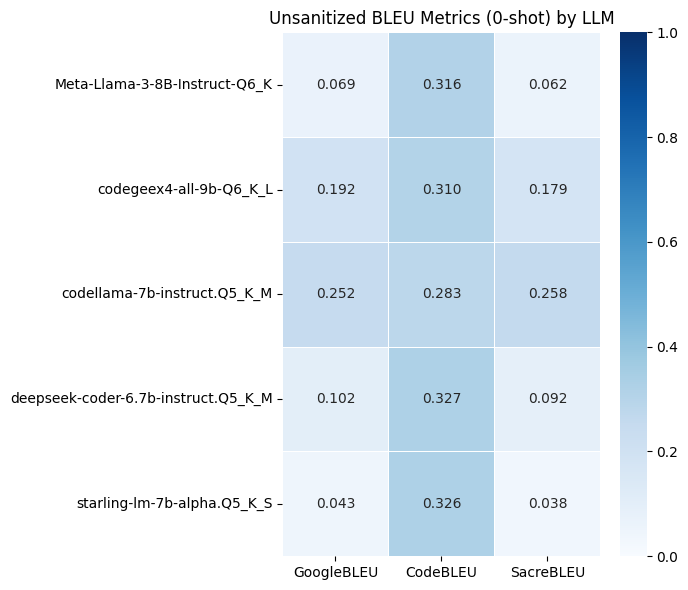

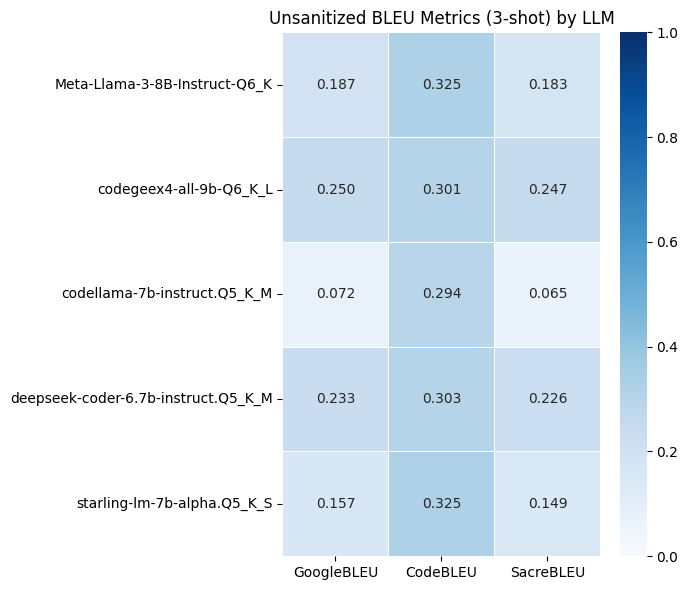

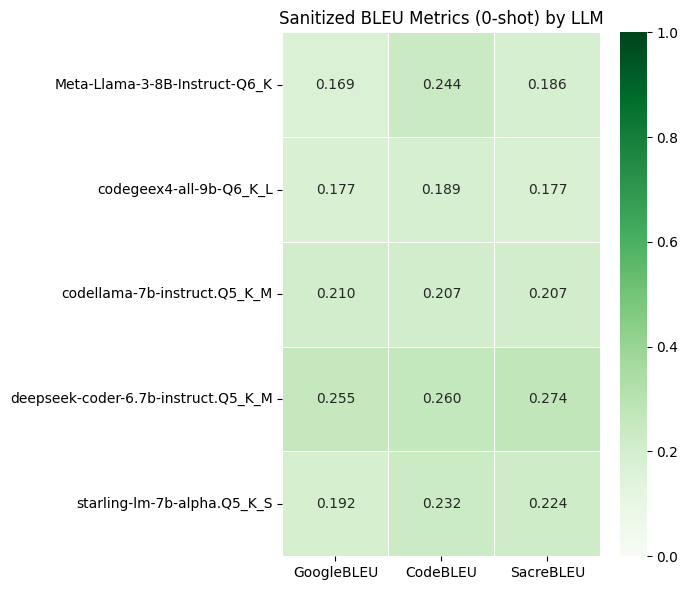

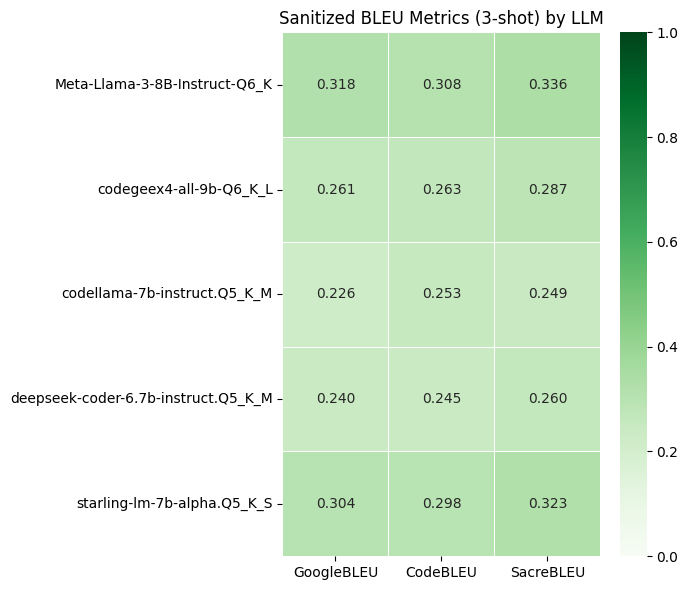

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_combined_mbpp is already defined

# Filter DataFrames for unsanitized BLEU metrics
df_bleu_unsanitized_0shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '0-shot'][['LLM', 'GoogleBLEU (unsanitized)', 'CodeBLEU (unsanitized)', 'SacreBLEU (unsanitized)']]
df_bleu_unsanitized_0shot.columns = ['LLM', 'GoogleBLEU', 'CodeBLEU', 'SacreBLEU']  # Rename columns
df_bleu_unsanitized_0shot = df_bleu_unsanitized_0shot.set_index('LLM')

df_bleu_unsanitized_3shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '3-shot'][['LLM', 'GoogleBLEU (unsanitized)', 'CodeBLEU (unsanitized)', 'SacreBLEU (unsanitized)']]
df_bleu_unsanitized_3shot.columns = ['LLM', 'GoogleBLEU', 'CodeBLEU', 'SacreBLEU']  # Rename columns
df_bleu_unsanitized_3shot = df_bleu_unsanitized_3shot.set_index('LLM')

# Filter DataFrames for sanitized BLEU metrics
df_bleu_sanitized_0shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '0-shot'][['LLM', 'GoogleBLEU (sanitized)', 'CodeBLEU (sanitized)', 'SacreBLEU (sanitized)']]
df_bleu_sanitized_0shot.columns = ['LLM', 'GoogleBLEU', 'CodeBLEU', 'SacreBLEU']  # Rename columns
df_bleu_sanitized_0shot = df_bleu_sanitized_0shot.set_index('LLM')

df_bleu_sanitized_3shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '3-shot'][['LLM', 'GoogleBLEU (sanitized)', 'CodeBLEU (sanitized)', 'SacreBLEU (sanitized)']]
df_bleu_sanitized_3shot.columns = ['LLM', 'GoogleBLEU', 'CodeBLEU', 'SacreBLEU']  # Rename columns
df_bleu_sanitized_3shot = df_bleu_sanitized_3shot.set_index('LLM')

width = 7
height = 6

# Create heatmap for unsanitized BLEU metrics - 0-shot
plt.figure(figsize=(width, height))
sns.heatmap(df_bleu_unsanitized_0shot, annot=True, cmap='Blues', fmt='.3f', linewidths=0.5, vmin=0, vmax=1)
plt.title('Unsanitized BLEU Metrics (0-shot) by LLM')
plt.xlabel('')
plt.ylabel('')
plt.ylim(len(df_bleu_unsanitized_0shot), 0)  # Reverse y-axis for better visual
plt.tight_layout()
plt.show()

# Create heatmap for unsanitized BLEU metrics - 3-shot
plt.figure(figsize=(width, height))
sns.heatmap(df_bleu_unsanitized_3shot, annot=True, cmap='Blues', fmt='.3f', linewidths=0.5, vmin=0, vmax=1)
plt.title('Unsanitized BLEU Metrics (3-shot) by LLM')
plt.xlabel('')
plt.ylabel('')
plt.ylim(len(df_bleu_unsanitized_3shot), 0)  # Reverse y-axis for better visual
plt.tight_layout()
plt.show()

# Create heatmap for sanitized BLEU metrics - 0-shot
plt.figure(figsize=(width, height))
sns.heatmap(df_bleu_sanitized_0shot, annot=True, cmap='Greens', fmt='.3f', linewidths=0.5, vmin=0, vmax=1)
plt.title('Sanitized BLEU Metrics (0-shot) by LLM')
plt.xlabel('')
plt.ylabel('')
plt.ylim(len(df_bleu_sanitized_0shot), 0)  # Reverse y-axis for better visual
plt.tight_layout()
plt.show()

# Create heatmap for sanitized BLEU metrics - 3-shot
plt.figure(figsize=(width, height))
sns.heatmap(df_bleu_sanitized_3shot, annot=True, cmap='Greens', fmt='.3f', linewidths=0.5, vmin=0, vmax=1)
plt.title('Sanitized BLEU Metrics (3-shot) by LLM')
plt.xlabel('')
plt.ylabel('')
plt.ylim(len(df_bleu_sanitized_3shot), 0)  # Reverse y-axis for better visual
plt.tight_layout()
plt.show()
